In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import datetime as dt

# initialize a connection to the database
import sqlite3
conn = sqlite3.connect('../Spotify_Challenge/dbsql.db')

# initialize another sqlalchemy connection to the same database to be able to query data straight to pandas dataframe
from sqlalchemy import create_engine
disk_engine = create_engine('sqlite:///../Spotify_Challenge/dbsql.db')

from sklearn.preprocessing import StandardScaler, Imputer, RobustScaler
from sklearn.cluster import KMeans

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
# functions
def clusterize_data(data,k,col_names,col_names_return,rescale_strategy = 'median',gen_plots=True):
    df = data[col_names]
    # treat missing data
    df = impute_na(df)
    # rescale data
    df = rescale_data(df,strategy=rescale_strategy)['data']
    # k cluster
    clusters = generate_clusters(df,k)
    data['CLASS'] = clusters['labels']
    
    if gen_plots:
        data.CLASS.hist()
        plt.show()
    return {'data':data[col_names_return],'centroids':clusters['centroids'],'labels':clusters['labels']}

def impute_na(data):
    cols = data.columns
    for col in cols:
        if data[data[col].isnull()].shape[0]>0:
            try:
                most_freq = data[col].mode()[0]
            except:
                most_freq = 0
            data.loc[data[data[col].isnull()].index.tolist(),col] = most_freq
    return data

def rescale_data(data, strategy = 'mean'):
    cols = data.columns
    if strategy == 'mean':
        s = StandardScaler()
    if strategy == 'median':
        s = RobustScaler(with_centering=True,with_scaling=True)
    data = s.fit_transform(data)
    data = pd.DataFrame(data,columns=cols)
    return {'data':data,'scaler':s}

def generate_clusters(data,k):
    km = KMeans(k)
    km.fit(data)
    centroids = km.cluster_centers_
    labels = km.labels_
    return {'centroids':centroids,'labels':labels}

def squared_clustering_errors(data,k):
    cl = clusterize_airlines(data,k,col_names=data.columns.tolist()[2:])
    centroids = cl['centroids']
    labels = cl['labels']
    assignments =map(lambda x:centroids[x],labels)
    return sum(map(lambda x,y:squared_distance(x,y),data[data.columns.tolist()[2:-1]].values,assignments ))

def optimize_k(data,ks):
    errors = []
    for k in ks:
        errors.append(squared_clustering_errors(data,k))
    plt.plot(ks,errors)
    plt.show()
    return zip(ks,errors)

# Cluster analysis

In this notebook, airports and flights are going to be set into clusters. But one would ask himself why clustering airports and/or flights.
Let me first remind the objective of the project. The goal of this project is to build a model that can predict how long a flight between two airports, **origin** and **destination**, in a given **airline** on a given **date** would be delayed. In other words, this model would ask only 4 variables from the users. However, the dataset available to us has about 22 features. So, in order to make use of all the rest of the features, I am going to cluster airports and flights using specific features hence embedding the rest of the variables into airports or flights. For instance, using airports geo-coordinates, airports can be clustered into 2 groups (east and west) or even more. Similarly, flights can be clustered using the distance between origin and destination or even average flight time.

### 1. Import data
#### 1.1. Airports

In [3]:
features = [u'index',u'YEAR', u'QUARTER', u'MONTH', u'DAY_OF_MONTH', u'DAY_OF_WEEK', u'AIRLINE_ID', 
            u'CARRIER', u'TAIL_NUM', u'FL_NUM', u'ORIGIN_AIRPORT_ID', u'ORIGIN', u'ORIGIN_CITY_NAME', 
            u'ORIGIN_STATE_NM', u'DEST_AIRPORT_ID', u'DEST', u'DEST_CITY_NAME', u'DEST_STATE_NM', 
            u'DEP_DELAY', u'DEP_DELAY_NEW', u'DEP_DEL15', u'TAXI_OUT', u'TAXI_IN', u'ARR_DELAY', 
            u'ARR_DELAY_NEW', u'ARR_DEL15', u'CANCELLED', u'CANCELLATION_CODE', u'DIVERTED', u'AIR_TIME', 
            u'FLIGHTS', u'DISTANCE', u'CARRIER_DELAY', u'WEATHER_DELAY', u'NAS_DELAY', u'SECURITY_DELAY', 
            u'LATE_AIRCRAFT_DELAY',u'FL_DATE']
years = (2010,2011,2012,2013,2014,2015)

In [4]:
# load airports data. This is the table containing coordinates of airports
airports = pd.read_sql_query('select iata, lat, long from airports',disk_engine)


# load all data aggregated by origin
tic = dt.datetime.now() #time the process
if 'agg_per_origin' in map(lambda x:x[0],conn.execute("select name from sqlite_master where type = 'table'").fetchall()):
    # load the table if it exists already
    df1 = pd.read_sql_query("SELECT * FROM agg_per_origin",disk_engine)
    if 'index' in df1.columns:
        df1.drop('index',axis=1,inplace=True)
else:
    # otherwise, query data from the database
    print "querying from raw data"
    df1 = pd.read_sql_query("SELECT YEAR, ORIGIN, SUM(FLIGHTS) AS FLIGHTS, SUM(DEP_DEL15) AS DEP_DEL, "
                            "SUM(DEP_DELAY) AS DDEL1, SUM(DEP_DELAY_NEW) AS DDEL2, SUM(CANCELLED) AS CANCELLED, "
                            "SUM(SECURITY_DELAY) AS SEC_DEL, SUM(CARRIER_DELAY) AS CAR_DEL, SUM(NAS_DELAY) AS NAS_DEL, "
                            "SUM(WEATHER_DELAY) AS WEA_DEL, SUM(LATE_AIRCRAFT_DELAY) AS LAD_DEL "
                            "FROM data "
                            "GROUP BY YEAR, ORIGIN",disk_engine)
    #push the aggregated data back to the database
    df1.to_sql('agg_per_origin',conn,index=False)
print dt.datetime.now()-tic #print the time taken for this operation


# load all data aggreagated by destination
tic = dt.datetime.now() #time the process
if 'agg_per_destination' in map(lambda x:x[0],conn.execute("select name from sqlite_master where type = 'table'").fetchall()):
    # load the table if it exists already
    df2 = pd.read_sql_query("SELECT * FROM agg_per_destination",disk_engine)
    if 'index' in df2.columns:
        df2.drop('index',axis=1,inplace=True)
else:
    # otherwise, query data from the database
    print "querying from raw data"
    df2 = pd.read_sql_query("SELECT YEAR, DEST, SUM(FLIGHTS) AS FLIGHTS, SUM(ARR_DEL15) AS ARR_DEL, "
                            "SUM(ARR_DELAY) AS ADEL1, SUM(ARR_DELAY_NEW) AS ADEL2, SUM(DIVERTED) AS DIVERTED "
                            "FROM data "
                            "GROUP BY YEAR, DEST",disk_engine)
    #push the aggregated data back to the database
    df2.to_sql('agg_per_destination',conn,index=False)
print dt.datetime.now()-tic #print the time taken for this operation


# put origin and destination data together
#loop through years and merge data in df1, df2 and airports per year and origin
tmp_df = pd.DataFrame()
for yoi in years:
    agg_df = pd.merge(df1[df1.YEAR == yoi],df2[df2.YEAR == yoi],left_on='ORIGIN',right_on='DEST')

    # append coordinates as well
    agg_df = pd.merge(agg_df,airports,left_on='ORIGIN', right_on='iata')
    agg_df.drop(['DEST','YEAR_y','iata'],axis=1,inplace=True)
    agg_df.rename(columns={'YEAR_x':'YEAR','FLIGHTS_x':'DEP_FLIGHTS','FLIGHTS_y':'ARR_FLIGHTS','ORIGIN':'IATA',
                           'lat':'LAT','long':'LON'}, inplace=True)
    # use RobustScaler to take care of outliers
    #rob_scaler = RobustScaler(with_centering=True,with_scaling=True)
    #indices = agg_df[agg_df.columns[2:-2]].dropna().index.tolist()
    #agg_df.loc[indices,agg_df.columns[2:-2]] = rob_scaler.fit_transform(agg_df[agg_df.columns[2:-2]].dropna().values)

    # assign aggregated data to airports
    tmp_df = pd.concat([tmp_df,agg_df],ignore_index=True)

#impute NA
#imputer = Imputer(strategy='most_frequent')
#tmp_df[['SEC_DEL','CAR_DEL','NAS_DEL','WEA_DEL','LAD_DEL']] = imputer.fit_transform(tmp_df[['SEC_DEL','CAR_DEL','NAS_DEL','WEA_DEL','LAD_DEL']])

# now let's normalize some features with respect to the number of departure flights 
features_to_normalize = ['DEP_FLIGHTS','DEP_DEL','DDEL1','DDEL2','CANCELLED','SEC_DEL','CAR_DEL','NAS_DEL',
                         'WEA_DEL','LAD_DEL','ARR_FLIGHTS','ARR_DEL','ADEL1','ADEL2','DIVERTED']
airports = tmp_df[['YEAR','IATA']]
for col in features_to_normalize:
    airports[col] = (tmp_df.loc[:,col]/tmp_df['DEP_FLIGHTS']).values
#airports = tmp_df.copy()

0:00:00.020073
0:00:00.049845


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### 1.2 Flights

### 2. Dataexploration

Here we will explore features to detect and remove colinearity and to reject outliers (data beyond $\mu$$\pm$ 3$\sigma$)

#### 2.1 Airports

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

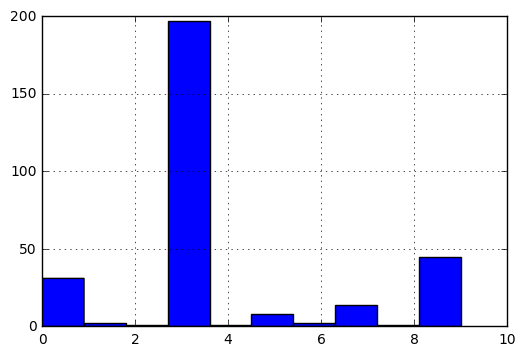

In [6]:
cols_to_return = ['YEAR','IATA','CLASS']
col_names = airports.columns[3:-2]
clst = clusterize_data(airports[airports.YEAR==2010],k=10,col_names=col_names,col_names_return=cols_to_return)

## =====!!!! NOT DONE !!!!=====